# Modeling with PyTorch

In [1]:
import komod
import ptmod

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import pickle

import matplotlib.pyplot as plt
# import seaborn as sns
# plt.style.use('seaborn')

%matplotlib inline

## Train/Test Dataset Creation

First, create a datagroup in the Mongo collection. Following the sax/no-sax convention, I'll use all the available samples with sax in foreground, and an equal number of those without.

In [2]:
# only run once!
# komod.create_datagroup_in_db('sax1203', 'sax')

Now that it's labeled in the database, I load the datagroup as a pd dataframe, add a train/test column, and then create PyTorch dataset objects. These spectros will be at 1/4 scale, larger than the 1/8 scale spectros used in development.

In [2]:
sax1203_datagroup = komod.pull_datagroup_from_db('sax1203')

In [4]:
# look at number of records with each label
sax1203_datagroup.actual.value_counts()

1    460
0    460
Name: actual, dtype: int64

In [7]:
sax1203_datagroup.sample(5)

,chunk_id,actual
478,009152,1
393,007624,1
730,015111,1
719,015015,1
285,005398,0


In [8]:
# creation of dataset objects for train and test sets

train_df, test_df = komod.tts(sax1203_datagroup)

train_4 = ptmod.SpectroDataset(train_df, scaling=0.25)
test_4 = ptmod.SpectroDataset(test_df, scaling=0.25)

print("Train set length:", len(train_4))
print("Test set length:", len(test_4))

Train set length: 733
Test set length: 187


A look at 5 records in the train set:

In [9]:
for i in range(5):
    item = train_4[i]
    print("\nChunk:", item[2])
    print("Label:", item[1])
    print("---")
    ptmod.tensor_stats(item[0])


Chunk: 000009
Label: 0
---
Min: -1.0
Max: 1.0
Mean: -0.25908217679108936
Std: 0.424969919429845
Shape: torch.Size([1, 128, 108])

Chunk: 000047
Label: 0
---
Min: -1.0
Max: 1.0
Mean: 0.011445257489091466
Std: 0.2823653199847814
Shape: torch.Size([1, 128, 108])

Chunk: 000064
Label: 0
---
Min: -1.0
Max: 1.0
Mean: -0.667392001937738
Std: 0.3322335200982037
Shape: torch.Size([1, 128, 108])

Chunk: 000108
Label: 0
---
Min: -1.0
Max: 1.0
Mean: 0.006972157547526107
Std: 0.30845731487670264
Shape: torch.Size([1, 128, 108])

Chunk: 000136
Label: 0
---
Min: -1.0
Max: 1.0
Mean: 0.01438710490623144
Std: 0.3315670103026427
Shape: torch.Size([1, 128, 108])


## CNN Architecture

Because of the (1,128,108) dimension of the images, we'll have to re-design the layers of the CNN.

In [10]:
cnn_layers_test = (
    (5,1,10),
    (2,2,0),
    (5,1,20),
    (2,2,0)
)

ptmod.cnn_pixels_out((1,128,108), cnn_layers_test, drop_last=True)

1 x 128 x 108
10 x 124 x 104
10 x 62 x 52
20 x 58 x 48
20 x 29 x 24


13920

I could try running it with 13920 values going into the FC layer, but will look at getting it down to the 400-3000 range.

In [11]:
cnn_layers = (
    (5,2,10),
    (2,2,0),
    (5,2,20),
    (2,2,0)
)

ptmod.cnn_pixels_out((1,128,108), cnn_layers, drop_last=True)

1 x 128 x 108
10 x 62 x 52
10 x 31 x 26
20 x 14 x 11
20 x 7 x 5


700

With a stride of 2 on each convolutional layer, this gets it down to 700. Worth a shot.

In [12]:
params_1 = {
    'c1': [5,2,10],
    'p1': [2,2],
    'c2': [5,2,20],
    'p2': [2,2],
    'f1': [700,100],
    'f2': [100,2]
}

cnn_700 = ptmod.CNN_cpcpff(params_1)
print(cnn_700)

CNN_cpcpff (
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(2, 2))
  (pool1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(2, 2))
  (pool2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (fc1): Linear (700 -> 100)
  (fc2): Linear (100 -> 2)
)


## Testing First Model

In [4]:
ptmod.fit(
    cnn_700,
    train_4, 
    optim.SGD(cnn_700.parameters(), lr=0.01), 
    nn.CrossEntropyLoss(), 
    20
)

Epoch 1
 * Avg loss: 0.692	Time: 7274.246 ms
Epoch 2
 * Avg loss: 0.686	Time: 6947.226 ms
Epoch 3
 * Avg loss: 0.673	Time: 7599.780 ms
Epoch 4
 * Avg loss: 0.660	Time: 7585.520 ms
Epoch 5
 * Avg loss: 0.639	Time: 7549.266 ms
Epoch 6
 * Avg loss: 0.631	Time: 7987.980 ms
Epoch 7
 * Avg loss: 0.613	Time: 7926.175 ms
Epoch 8
 * Avg loss: 0.594	Time: 7938.627 ms
Epoch 9
 * Avg loss: 0.564	Time: 8015.641 ms
Epoch 10
 * Avg loss: 0.522	Time: 8203.070 ms
Epoch 11
 * Avg loss: 0.497	Time: 8089.379 ms
Epoch 12
 * Avg loss: 0.474	Time: 8550.252 ms
Epoch 13
 * Avg loss: 0.457	Time: 7960.489 ms
Epoch 14
 * Avg loss: 0.450	Time: 8022.415 ms
Epoch 15
 * Avg loss: 0.426	Time: 8199.469 ms
Epoch 16
 * Avg loss: 0.418	Time: 8791.102 ms
Epoch 17
 * Avg loss: 0.417	Time: 7966.831 ms
Epoch 18
 * Avg loss: 0.395	Time: 8240.990 ms
Epoch 19
 * Avg loss: 0.362	Time: 7881.802 ms
Epoch 20
 * Avg loss: 0.363	Time: 7975.317 ms

Training Complete!


CNN_cpcpff (
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(2, 2))
  (pool1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(2, 2))
  (pool2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (fc1): Linear (700 -> 100)
  (fc2): Linear (100 -> 2)
)

In [6]:
cnn_700.save_myself('cnn700_171203_1109')

In [5]:
train_4_pred = ptmod.predict(cnn_700, train_4)
test_4_pred = ptmod.predict(cnn_700, test_4)

In [13]:
cnn_700_scores = ptmod.get_scores(train_4_pred, test_4_pred)

MODEL SCORES
Score	Train	Test
------------------------
Acc	0.807	0.780
Rec	0.636	0.611
Spec	0.978	0.948


Much better than the first attempt! Doesn't look like it's overfitting. What happens with more epochs?

### Bumping Up Number of Epochs

In [5]:
# instantiate a new model object
cnn_700_2 = ptmod.CNN_cpcpff(params_1)
print(cnn_700_2)

CNN_cpcpff (
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(2, 2))
  (pool1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(2, 2))
  (pool2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (fc1): Linear (700 -> 100)
  (fc2): Linear (100 -> 2)
)


In [6]:
cnn_700_2, cnn_700_2_loss = ptmod.fit(
    cnn_700_2,
    train_4, 
    optim.SGD(cnn_700_2.parameters(), lr=0.01), 
    nn.CrossEntropyLoss(), 
    50
)

Epoch 1
 * Avg loss: 0.692	Time: 7558.088 ms
Epoch 2
 * Avg loss: 0.683	Time: 6802.814 ms
Epoch 3
 * Avg loss: 0.664	Time: 7288.173 ms
Epoch 4
 * Avg loss: 0.644	Time: 8410.750 ms
Epoch 5
 * Avg loss: 0.631	Time: 8523.485 ms
Epoch 6
 * Avg loss: 0.606	Time: 9145.294 ms
Epoch 7
 * Avg loss: 0.587	Time: 7804.300 ms
Epoch 8
 * Avg loss: 0.549	Time: 7759.554 ms
Epoch 9
 * Avg loss: 0.540	Time: 7861.447 ms
Epoch 10
 * Avg loss: 0.517	Time: 7759.850 ms
Epoch 11
 * Avg loss: 0.498	Time: 7757.904 ms
Epoch 12
 * Avg loss: 0.504	Time: 7849.624 ms
Epoch 13
 * Avg loss: 0.479	Time: 7734.679 ms
Epoch 14
 * Avg loss: 0.459	Time: 7812.079 ms
Epoch 15
 * Avg loss: 0.455	Time: 7728.856 ms
Epoch 16
 * Avg loss: 0.443	Time: 7777.609 ms
Epoch 17
 * Avg loss: 0.428	Time: 9333.158 ms
Epoch 18
 * Avg loss: 0.423	Time: 8371.256 ms
Epoch 19
 * Avg loss: 0.385	Time: 7733.986 ms
Epoch 20
 * Avg loss: 0.399	Time: 7677.977 ms
Epoch 21
 * Avg loss: 0.364	Time: 7748.486 ms
Epoch 22
 * Avg loss: 0.360	Time: 7806.963 

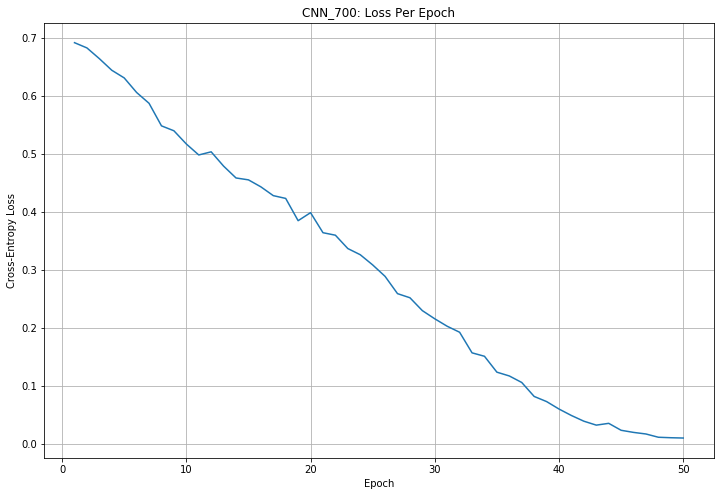

In [18]:
x, y = list(range(1,51)), cnn_700_2_loss

fig = plt.figure(figsize=(12,8))
plt.plot(x,y)
plt.grid(b=True)
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("CNN_700: Loss Per Epoch");

In [12]:
train_4_pred2 = ptmod.predict(cnn_700_2, train_4)
test_4_pred2 = ptmod.predict(cnn_700_2, test_4)

In [13]:
cnn_700_scores = ptmod.get_scores(train_4_pred2, test_4_pred2)

MODEL SCORES
Score	Train	Test
------------------------
Acc	1.000	0.775
Rec	1.000	0.768
Spec	1.000	0.781


Clearly overfitting -- seriously learned the training set. I'll have to back off on model complexity and/or epochs. Need to do some CV/Grid Search.

In [26]:
# cnn_700_50_loss_and_predicts = {
#     'loss': cnn_700_2_loss,
#     'train_df': train_4_pred2,
#     'test_df': test_4_pred2
# }

In [27]:
# save for later
# with open('../data/cnn_700_50_loss_and_predicts.p', 'wb') as pf:
#     pickle.dump(cnn_700_50_loss_and_predicts, pf)